# UM-Bridge with QMCPy

Using QMCPy to evaluate the [UM-Bridge Cantilever Beam Function](https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/muq-beam-propagation.html) and approximate the expectation with respect to a uniform random variable. 

## Imports

In [9]:
import umbridge
import qmcpy as qp
import numpy as np
import time
import docker

## Start Docker Container

See the [UM-Bridge Documentation](https://um-bridge-benchmarks.readthedocs.io/en/docs/index.html) for image options. 

In [2]:
!docker run -it -d -p 4242:4242 linusseelinger/model-muq-beam:latest
#!docker run --name muqbp_new -d -p 4242:4242 my-build
#https://stackoverflow.com/questions/43099116/error-the-input-device-is-not-a-tty
#running locally

2b485b5472f0425f503d9047d354104ebb75579bb2ebcb27dded67a139ebf7f1
docker: Error response from daemon: driver failed programming external connectivity on endpoint crazy_keldysh (27390a44f98d9517a346bb5be4bc6b8dd5032ab298c2a295eb5444eaf7ffe4fe): Bind for 0.0.0.0:4242 failed: port is already allocated.


## Problem Setup

Initialize a QMCPy sampler and distribution.

In [3]:
sampler = qp.DigitalNetB2(dimension=3,seed=7) # DISCRETE DISTRIBUTION, default = 3
distribution = qp.Uniform(sampler,lower_bound=1,upper_bound=1.05) # TRUE MEASURE

Initialize a UM-Bridge model and wrap it into a QMCPy compatible Integrand

In [14]:
model = umbridge.HTTPModel('http://localhost:4242', 'forward')
output_dimension = 31
umbridge_config = {}
#DEBUG
print(umbridge_config)
print(model.get_input_sizes(umbridge_config))
print(model.get_output_sizes(umbridge_config))
print(distribution.d)

def lump(t):
    tnp = np.array(t[0])
    tnewnp = np.ones(output_dimension)
    tnewnp[:len(tnp)] = tnp
    return [tnewnp.tolist()]

integrand = qp.UMBridgeWrapper(distribution, model, umbridge_config, parallel=False,tf_input_to_umbridge_input = lump) # INTEGRAND

{}
[31]
[31]
3


## Model Evaluation

In [15]:
start_time = time.time()
x = sampler(16) # same as sampler.gen_samples(16)
print(x.shape)
y = integrand.f(x)
print(y.shape)
print(type(y))
print(y.dtype)
print(y)
end_time = time.time()
print(end_time - start_time)

(16, 3)
(16, 31)
<class 'numpy.ndarray'>
float64
[[    0.            50.23109959   196.14982498   429.86148257
    747.13504682  1141.91833427  1608.38048717  2140.91121316
   2734.12086877  3382.83893902  4082.11320566  4827.21143275
   5613.62362872  6437.06523665  7293.47965238  8179.04105745
   9090.15752336 10023.47516267 10975.88059814 11944.50213951
  12926.70953056 13920.11268465 14922.55909892 15932.13153207
  16947.14526357 17966.14605169 18987.90823201 20011.43291039
  21035.94612281 22060.89704752 23085.95693322]
 [    0.            50.6636738    194.81163715   424.69989056
    738.15005062  1129.10993389  1591.74868262  2120.45600442
   2709.84225585  3354.73692192  4050.18778438  4791.46260729
   5574.05139909  6393.66960284  7246.26061439  8127.99861528
   9035.291677    9964.78591214 10913.36794342 11878.16608062
  12856.55006749 13846.12981739 14844.75282749 15850.50185645
  16861.69218378 17876.86956772 18894.80834385 19914.50961806
  20935.1994263  21956.32694683 229

## Automatically Approximate the Expectation

In [42]:
qmc_stop_crit = qp.CubQMCNetG(integrand,abs_tol=10) # QMC STOPPING CRITERION
#takes ~6 seconds when error tol >= 0.25, ~12 seconds at tol=0.025
solution,data = qmc_stop_crit.integrate()
print(data)

LDTransformData (AccumulateData Object)
    solution        [    0.       47.403   183.785 ... 19837.438 20807.061 21776.79 ]
    comb_bound_low  [    0.       47.393   183.746 ... 19834.606 20804.111 21773.722]
    comb_bound_high [    0.       47.413   183.824 ... 19840.269 20810.01  21779.858]
    comb_flags      [ True  True  True ...  True  True  True]
    n_total         2^(10)
    n               [1024. 1024. 1024. ... 1024. 1024. 1024.]
    time_integrate  49.228
CubQMCNetG (StoppingCriterion Object)
    abs_tol         10
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.050
DigitalNetB2 (DiscreteDistribution Object)
    d               31
    dvec            [ 0  1  2 ... 28 29 30]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()


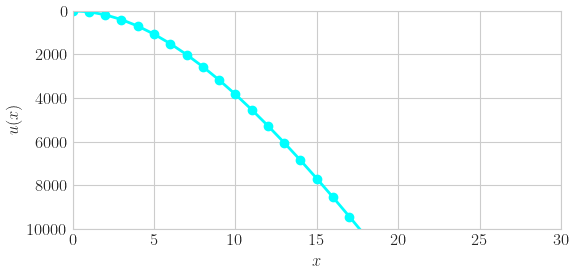

In [44]:
from matplotlib import pyplot
pyplot.style.use('../qmcpy.mplstyle')
fig,ax = pyplot.subplots(figsize=(6,3))
ax.plot(solution,'-o')
ax.set_xlim([0,len(solution)-1]); ax.set_xlabel(r'$x$')
ax.set_ylim([10000,-10]);  ax.set_ylabel(r'$u(x)$');

## Parallel Evaluation

QMCPy can automatically multi-threaded requests to the model by setting `parallel=p` where `p` is the number of processors used by [multiprocessing.pool.ThreadPool](https://docs.python.org/3/library/multiprocessing.html#multiprocessing.pool.ThreadPool). Setting `parallel=True` is equivalent to setting `paralle=os.cpu_count()`.

In [28]:
import os
print('Available CPUs: %d'%os.cpu_count())

Available CPUs: 8


In [47]:
integrand = qp.UMBridgeWrapper(distribution,model,umbridge_config,parallel=8)
solution,data = qp.CubQMCNetG(integrand,abs_tol=2.5e-2).integrate()
data

LDTransformData (AccumulateData Object)
    solution        2.050
    comb_bound_low  2.050
    comb_bound_high 2.050
    comb_flags      1
    n_total         2^(10)
    n               2^(10)
    time_integrate  5.043
CubQMCNetG (StoppingCriterion Object)
    abs_tol         0.025
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
UMBridgeWrapper (Integrand Object)
Uniform (TrueMeasure Object)
    lower_bound     1
    upper_bound     1.050
DigitalNetB2 (DiscreteDistribution Object)
    d               2^(2)
    dvec            [0 1 2 3]
    randomize       LMS_DS
    graycode        0
    entropy         7
    spawn_key       ()

## Shut Down Docker Image

In [67]:
!docker rm -f muqbp_new

muqbp_new
